In [1]:
import os, sys, io
import datetime
import joblib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras import initializers
import tensorflow as tf

from sklearn import model_selection

sys.path.append('%s/lib' % (os.path.abspath('..')))
from SyntheticLCGenerator import synthetic_light_curve_generator
from nets_ae_clf import *

Using TensorFlow backend.


In [2]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# Main Path
main_path = os.path.abspath('..')

# To make sure that we can reproduce the experiment and get the same results
# np.random.seed(10)

In [3]:
def load_synthetic_time_series(data_path=None, n_samples=14000, seq_length=50,
                               time_span=4, n_bands=1, n_signals=1, SNR_min=5,
                               f0_interval='narrow',
                               use_time=True, use_err=True):

    if f0_interval == 'narrow':
        f0_inter = [1/10., 1/1.]
    elif f0_interval == 'wide':
        f0_inter = [1/100., 1/0.01]
    else:
        print('Plese define frequency interval...')
        return

    if os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = np.load(data_path).item()
        samples = aux['samples']
        labels = np.array(aux['labels'])[:, None]
        periods = aux['periods']
        if n_bands == 1:
            samples = samples.reshape(samples.shape[0], samples.shape[2],
                                      samples.shape[3])
        del aux
        if use_time and not use_err:
            samples = samples[:, :, 0:2]
        if not use_time and not use_err:
            samples = samples[:, :, 1:2]
    return samples, labels, periods


def load_real_time_series(data_path=None, survey='EROS2', n_bands=2,
                          use_time=True, use_err=True):

    if os.path.exists(data_path):
        print('Loading from: ', data_path)
        aux = joblib.load(data_path)
        lcs = aux['lcs']
        meta = aux['meta']
        del aux
        lcs = np.stack([x.values for x in lcs])
        print(lcs.shape)
        if n_bands == 1:
            lcs = lcs[:, :, 0:3]
        if use_time and not use_err:
            lcs = lcs[:, :, 0:2]
        if not use_time and not use_err:
            lcs = lcs[:, :, 1:2]
    return lcs, meta

In [40]:
list(range(4))

[0, 1, 2, 3]

In [41]:
# You will use the Adam optimizer
def get_optimizer(learning_rate):
    return Adam(lr=learning_rate)


def get_generator(optimizer, n_units, latent_dim, out_lc_len, n_feat,
                  dropout=0.1, m_type='LSTM',
                  n_layers=1, bdir=True):
    generator, param_str, param_dict = net_dTCN_pb(latent_dim, n_feat, n_units, 2,
                                                   max_dilation=4,
                                                   max_lenght=out_lc_len,
                                                   drop_frac=dropout,
                                                   causal=bdir,
                                                   kernel_size=5,
                                                   return_sequences=True)

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    generator.name = 'Generator'
    return generator


def get_discriminator(optimizer, n_units, lc_len, n_feat,
                      dropout=0.1, m_type='LSTM',
                      n_layers=1, bdir=True):
    discriminator, param_str, param_dict = net_dTCN_pb(n_feat, 1, n_units, 2,
                                                       max_dilation=4,
                                                       max_lenght=lc_len,
                                                       drop_frac=dropout,
                                                       causal=bdir,
                                                       kernel_size=5,
                                                       return_sequences=False)

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,
                          metrics=['acc'])
    discriminator.name = 'Discriminator'
    return discriminator

In [5]:
def get_gan_network(discriminator, latent_dim, out_lc_len, generator, optimizer):

    # We initially set trainable to False since we only want
    # to train either the generator or discriminator at a time
    discriminator.trainable = False

    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(out_lc_len, latent_dim), name='gan_input')

    # the output of the generator (an image)
    x = generator(gan_input)

    # get the output of the discriminator
    # (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    return gan

#  Extra functions

In [6]:
# Create a wall of generated time series
def plot_generated_time_series(epoch, generated_lc, test_lc=None, examples=8,
                               dim=(2, 4), figsize=(16, 4)):

    fig, ax = plt.subplots(nrows=dim[0], ncols=dim[1], figsize=figsize)
    for i in range(dim[0]):
        for j in range(dim[1]):
            if use_time and use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].errorbar(test_lc[i, :, 0], test_lc[i, :, 1],
                                     yerr=test_lc[i, :, 2], fmt='k.')
                else:
                    ax[i,j].errorbar(generated_lc[(j+i) + j, :, 0], generated_lc[(j+i) + j, :, 1],
                                     yerr=generated_lc[(j+i) + j, :, 2], fmt='b.')
            elif use_time and not use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].plot(test_lc[i, :, 0], test_lc[i, :, 1], 'k.')
                else:
                    ax[i,j].plot(generated_lc[(j+i) + j, :, 0], generated_lc[(j+i) + j, :, 1], 'b.')
            elif not use_time and not use_err:
                if j == 0 and test_lc is not None:
                    ax[i,j].plot(test_lc[i, :], 'k.')
                else:
                    ax[i,j].plot(generated_lc[(j+i) + j, :], 'b.')
    plt.tight_layout()
    # plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.show()
    return buf

In [7]:
def write_log_scalar(callback, names, logs, step):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, step)
        callback.writer.flush()
        
def write_log_plot(callback, buf, step):
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    summary = tf.summary.image("Generated_Image", image,
                               max_outputs=1)
    callback.writer.add_summary(tf.keras.backend.eval(summary), step)
    callback.writer.flush()

In [8]:
def normalize(data, norm_time=False, scale_to=[0, 1], n_feat=2):
    normed = np.zeros_like(data)
    for i, lc in enumerate(data):
        normed[i, :, n_feat-1] = (lc[:, n_feat-1] - np.min(lc[:, n_feat-1])) / \
            (np.max(lc[:, n_feat-1]) - np.min(lc[:, n_feat-1]))
        if scale_to != [0, 1]:
            normed[i, :, n_feat-1] = (normed[i, :, n_feat-1] * (scale_to[1] - scale_to[0])) + scale_to[0]
        if norm_time:
            normed[i, :, n_feat-2] = (lc[:, n_feat-2] - np.min(lc[:, n_feat-2])) / \
                (np.max(lc[:, n_feat-2]) - np.min(lc[:, n_feat-2]))
            if scale_to != [0, 1]:
                normed[i, :, n_feat-2] = (normed[i, :, n_feat-2] * (scale_to[1] - scale_to[0])) + scale_to[0]
        else:
            normed[i, :, n_feat-2] = lc[:, n_feat-2]
    return normed


def standarize(data, stand_time=False):
    standar = np.zeros_like(data)
    for i, lc in enumerate(data):
        standar[i, :, 1] = (lc[:, 1] - np.mean(lc[:, 1])) / np.std(lc[:, 1])
        if stand_time:
            standar[i, :, 0] = (lc[:, 0] - np.mean(lc[:, 0])) / np.std(lc[:, 0])
        else:
            standar[i, :, 0] = lc[:, 0]
    return standar


def get_noise(n_samples, n_timesteps=50, latent_dim=5, use_time=True):
    latent = np.random.normal(loc=0, scale=.2,
                              size=[n_samples, n_timesteps, latent_dim])
    if use_time:
        latent[:, :, 0] = sample_time(n=n_timesteps)
    return latent


def sample_time(n=50, t_range=[0, 4], irregular=True):
    time = np.linspace(t_range[0], t_range[1], num=n*10)
    time = np.random.choice(time, size=n, replace=False)
    return np.sort(time)

# 3. Settings

In [34]:
# data
n_samples = 28000
n_obs = 100
n_bands = 1
use_time = True
use_err = True
n_feat = 3
if (use_time and not use_err) or (not use_time and use_err):
    n_feat = 2
elif not use_time and not use_err:
    n_feat = 1
data_name = 'SynSine_time%s_err%s' % (str(use_time)[0], str(use_err)[0])
# data_name = 'EROS2_trim215_augmented'

# GAN architecture
model_name = 'dTCN_GAN'
learning_rate = 0.5 # [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
latent_dim = 5
D_hidden_units = 4  # [2, 4, 8, 16, 32, 64, 128]
G_hidden_units = 4
D_output = 1
G_dropout = 0.1
D_dropout = 0.1
batch_size = 7*8
n_epochs = 200
N_gen_feat = n_feat
save_interval = 5
viz_interval = 10
batch_count = round(14000*.6 / batch_size)
n_examples = 8
gen_lc_len = n_obs

# 2. Retrieve data

In [23]:
data_path = ('%s/data/synthetic/sine_nsamples%i_seqlength%i_nbands%i_nsig%i_timespan%i_SNR%i_f0%s.npy'
             % (main_path, 28000, 100, 1, 1, 4, 3, 'narrow'))
samples, labels, periods = load_synthetic_time_series(data_path, use_time=use_time, use_err=use_err)

# samples = normalize(samples[:14000], norm_time=True, scale_to=[-1, 1], n_feat=n_feat)
samples = samples[:14000]
labels = labels[:14000]
periods = periods[:14000]

print('Samples shape: ', samples.shape)

[x_train, x_test, 
 y_train, y_test] = model_selection.train_test_split(samples, labels, 
                                                     train_size=0.6)

Loading from:  /Users/jorgetil/Astro/TL-GANs/data/synthetic/sine_nsamples28000_seqlength100_nbands1_nsig1_timespan4_SNR3_f0narrow.npy
Samples shape:  (14000, 100, 3)


Real LC from sample...


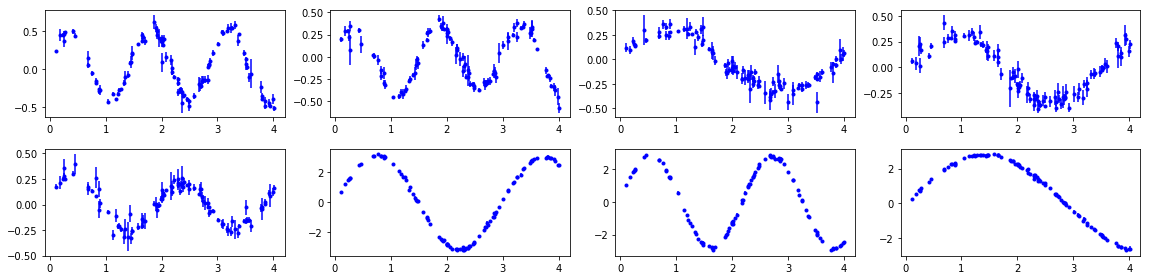

Latend space sample...


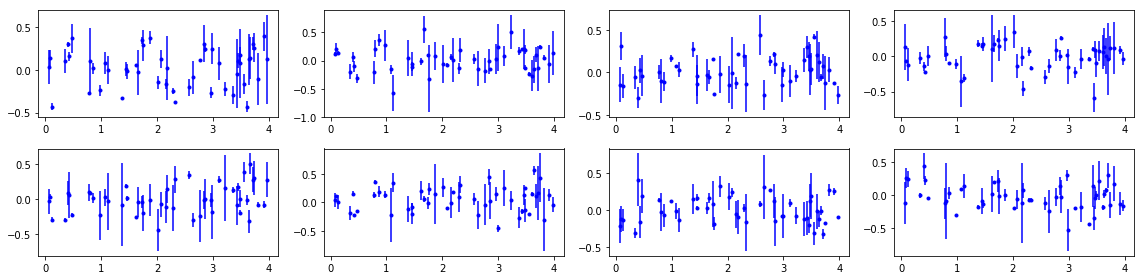

In [29]:
print('Real LC from sample...')
vis_real_idx = np.random.randint(0, len(samples), size=8)
vis_real = samples[vis_real_idx, :, :]
_ = plot_generated_time_series(0, vis_real, examples=8)
print('Latend space sample...')
vis_Z = get_noise(batch_size, n_timesteps=n_obs,
                 latent_dim=latent_dim, use_time=use_time)
_ = plot_generated_time_series(0, vis_Z, examples=8)

########## Learning Rate: 0.0001 ##########
##########      N Unites: 16     ##########
>>>> param_str =  dTCN_pb1_n16_drop10_stack2_dil4_cv5_cvW1_out3_outW3_aW_cW
>>>> param_str =  dTCN_pb1_n16_drop10_stack2_dil4_cv5_cvW1_out1_outW1_aW_cW
generator
discriminator
GAN
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gan_input (InputLayer)       (None, 100, 5)            0         
_________________________________________________________________
Generator (Model)            (None, 100, 3)            13295     
_________________________________________________________________
Discriminator (Model)        (None, 1)                 13138     
Total params: 26,433
Trainable params: 13,295
Non-trainable params: 13,138
_________________________________________________________________
None
--------------- Epoch 1 ---------------


1 [D loss: 7.931396, acc: 0%] [G loss: 0.000000]


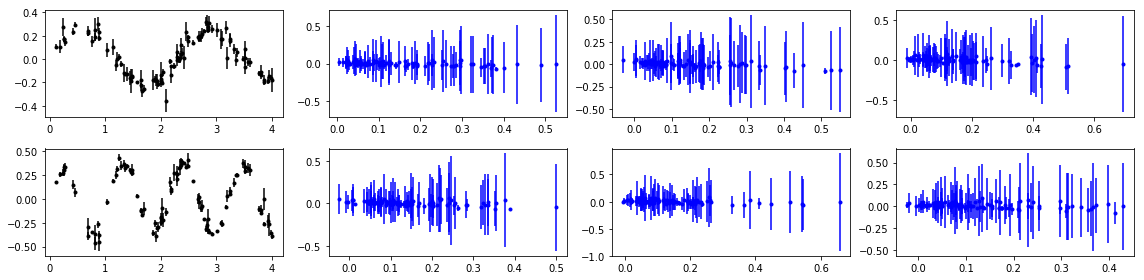

--------------- Epoch 2 ---------------


2 [D loss: 7.959359, acc: 0%] [G loss: 0.000000]
--------------- Epoch 3 ---------------


3 [D loss: 7.997810, acc: 0%] [G loss: 0.000000]
--------------- Epoch 4 ---------------


4 [D loss: 8.036220, acc: 0%] [G loss: 0.000000]
--------------- Epoch 5 ---------------


5 [D loss: 7.845291, acc: 0%] [G loss: 0.000000]
--------------- Epoch 6 ---------------


6 [D loss: 7.945503, acc: 0%] [G loss: 0.000000]
--------------- Epoch 7 ---------------


7 [D loss: 8.042174, acc: 0%] [G loss: 0.000000]
--------------- Epoch 8 ---------------


8 [D loss: 8.002554, acc: 0%] [G loss: 0.000000]
--------------- Epoch 9 ---------------


9 [D loss: 7.956295, acc: 0%] [G loss: 0.000000]
--------------- Epoch 10 ---------------


10 [D loss: 7.978447, acc: 0%] [G loss: 0.000000]


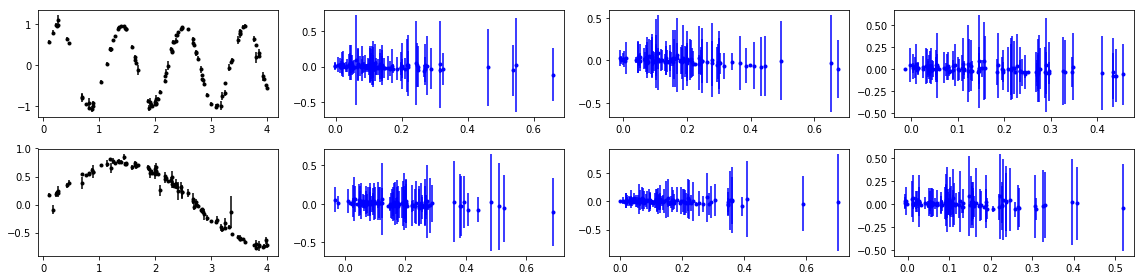

--------------- Epoch 11 ---------------


11 [D loss: 7.986844, acc: 0%] [G loss: 0.000000]
--------------- Epoch 12 ---------------


12 [D loss: 8.005106, acc: 0%] [G loss: 0.000000]
--------------- Epoch 13 ---------------


13 [D loss: 8.070678, acc: 0%] [G loss: 0.000000]
--------------- Epoch 14 ---------------


14 [D loss: 7.939919, acc: 0%] [G loss: 0.000000]
--------------- Epoch 15 ---------------


15 [D loss: 8.024788, acc: 0%] [G loss: 0.000000]
--------------- Epoch 16 ---------------


16 [D loss: 8.002786, acc: 0%] [G loss: 0.000000]
--------------- Epoch 17 ---------------


17 [D loss: 7.844505, acc: 0%] [G loss: 0.000000]
--------------- Epoch 18 ---------------


18 [D loss: 7.919369, acc: 0%] [G loss: 0.000000]
--------------- Epoch 19 ---------------


19 [D loss: 7.876937, acc: 0%] [G loss: 0.000000]
--------------- Epoch 20 ---------------


20 [D loss: 7.900396, acc: 0%] [G loss: 0.000000]


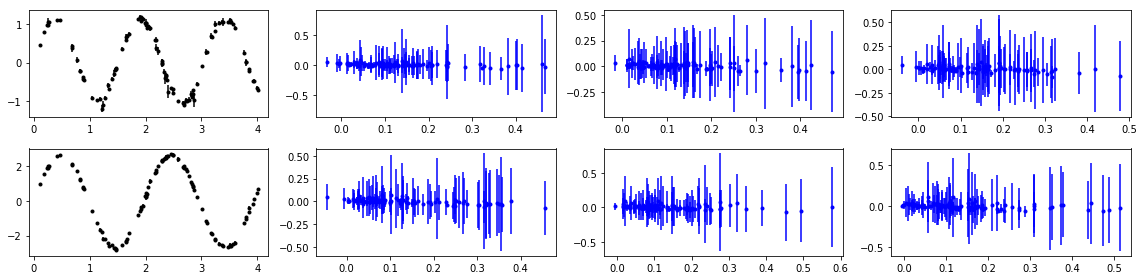

--------------- Epoch 21 ---------------


21 [D loss: 7.994080, acc: 0%] [G loss: 0.000000]
--------------- Epoch 22 ---------------


22 [D loss: 7.931768, acc: 0%] [G loss: 0.000000]
--------------- Epoch 23 ---------------


23 [D loss: 7.987764, acc: 0%] [G loss: 0.000000]
--------------- Epoch 24 ---------------


24 [D loss: 7.990219, acc: 0%] [G loss: 0.000000]
--------------- Epoch 25 ---------------


25 [D loss: 7.928850, acc: 0%] [G loss: 0.000000]
--------------- Epoch 26 ---------------


26 [D loss: 7.934669, acc: 0%] [G loss: 0.000000]
--------------- Epoch 27 ---------------


27 [D loss: 8.032420, acc: 0%] [G loss: 0.000000]
--------------- Epoch 28 ---------------


28 [D loss: 7.939332, acc: 0%] [G loss: 0.000000]
--------------- Epoch 29 ---------------


29 [D loss: 7.989409, acc: 0%] [G loss: 0.000000]
--------------- Epoch 30 ---------------


30 [D loss: 7.955323, acc: 0%] [G loss: 0.000000]


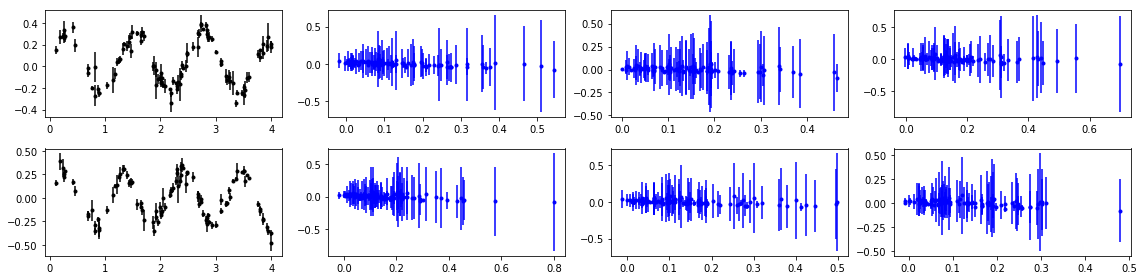

--------------- Epoch 31 ---------------


31 [D loss: 7.958277, acc: 0%] [G loss: 0.000000]
--------------- Epoch 32 ---------------


32 [D loss: 7.897770, acc: 0%] [G loss: 0.000000]
--------------- Epoch 33 ---------------


33 [D loss: 7.957406, acc: 0%] [G loss: 0.000000]
--------------- Epoch 34 ---------------


34 [D loss: 7.990879, acc: 0%] [G loss: 0.000000]
--------------- Epoch 35 ---------------


35 [D loss: 7.934563, acc: 0%] [G loss: 0.000000]
--------------- Epoch 36 ---------------


36 [D loss: 7.954963, acc: 0%] [G loss: 0.000000]
--------------- Epoch 37 ---------------


37 [D loss: 8.033648, acc: 0%] [G loss: 0.000000]
--------------- Epoch 38 ---------------


38 [D loss: 7.906895, acc: 0%] [G loss: 0.000000]
--------------- Epoch 39 ---------------


39 [D loss: 7.949864, acc: 0%] [G loss: 0.000000]
--------------- Epoch 40 ---------------


40 [D loss: 7.966287, acc: 0%] [G loss: 0.000000]


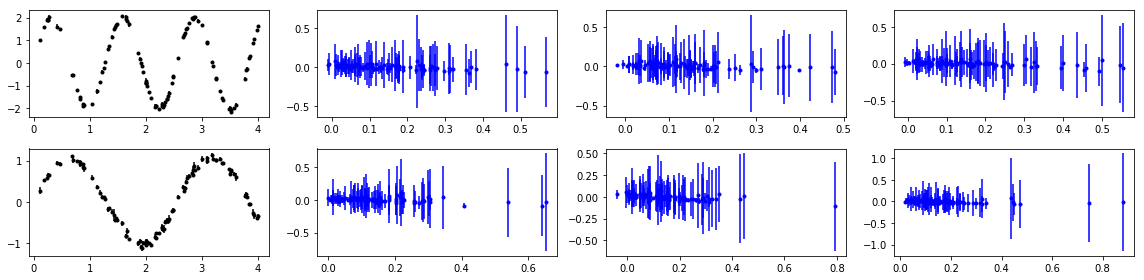

--------------- Epoch 41 ---------------


41 [D loss: 7.950217, acc: 0%] [G loss: 0.000000]
--------------- Epoch 42 ---------------


42 [D loss: 8.063689, acc: 0%] [G loss: 0.000000]
--------------- Epoch 43 ---------------


43 [D loss: 7.950726, acc: 0%] [G loss: 0.000000]
--------------- Epoch 44 ---------------


44 [D loss: 7.925213, acc: 0%] [G loss: 0.000000]
--------------- Epoch 45 ---------------


45 [D loss: 7.989967, acc: 0%] [G loss: 0.000000]
--------------- Epoch 46 ---------------


46 [D loss: 7.855669, acc: 0%] [G loss: 0.000000]
--------------- Epoch 47 ---------------


47 [D loss: 7.961796, acc: 0%] [G loss: 0.000000]
--------------- Epoch 48 ---------------


48 [D loss: 7.898574, acc: 0%] [G loss: 0.000000]
--------------- Epoch 49 ---------------


49 [D loss: 7.961247, acc: 0%] [G loss: 0.000000]
--------------- Epoch 50 ---------------


50 [D loss: 7.952165, acc: 0%] [G loss: 0.000000]


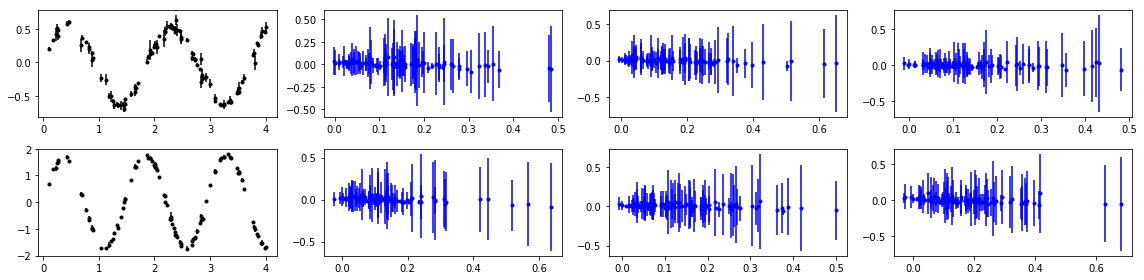

--------------- Epoch 51 ---------------


51 [D loss: 8.028285, acc: 0%] [G loss: 0.000000]
--------------- Epoch 52 ---------------


52 [D loss: 7.971675, acc: 0%] [G loss: 0.000000]
--------------- Epoch 53 ---------------


53 [D loss: 8.029168, acc: 0%] [G loss: 0.000000]
--------------- Epoch 54 ---------------


54 [D loss: 7.881434, acc: 0%] [G loss: 0.000000]
--------------- Epoch 55 ---------------


55 [D loss: 8.009597, acc: 0%] [G loss: 0.000000]
--------------- Epoch 56 ---------------


56 [D loss: 7.961358, acc: 0%] [G loss: 0.000000]
--------------- Epoch 57 ---------------


57 [D loss: 7.926591, acc: 0%] [G loss: 0.000000]
--------------- Epoch 58 ---------------


58 [D loss: 7.909512, acc: 0%] [G loss: 0.000000]
--------------- Epoch 59 ---------------


59 [D loss: 7.973893, acc: 0%] [G loss: 0.000000]
--------------- Epoch 60 ---------------


60 [D loss: 8.057981, acc: 0%] [G loss: 0.000000]


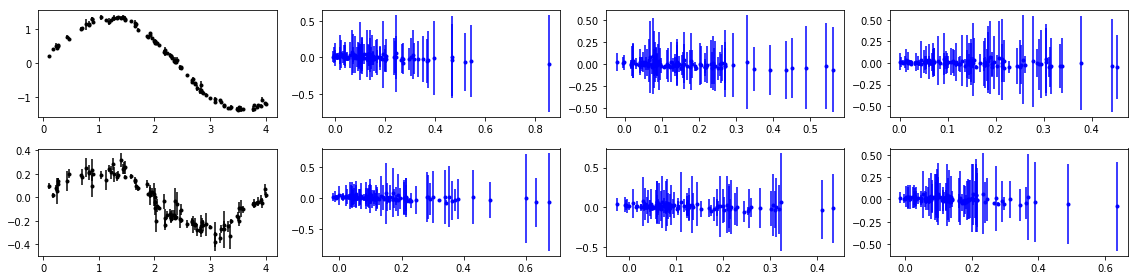

--------------- Epoch 61 ---------------


61 [D loss: 8.001658, acc: 0%] [G loss: 0.000000]
--------------- Epoch 62 ---------------


62 [D loss: 7.982152, acc: 0%] [G loss: 0.000000]
--------------- Epoch 63 ---------------


63 [D loss: 7.947964, acc: 0%] [G loss: 0.000000]
--------------- Epoch 64 ---------------


64 [D loss: 7.966178, acc: 0%] [G loss: 0.000000]
--------------- Epoch 65 ---------------


65 [D loss: 7.959180, acc: 0%] [G loss: 0.000000]
--------------- Epoch 66 ---------------


66 [D loss: 7.952129, acc: 0%] [G loss: 0.000000]
--------------- Epoch 67 ---------------


67 [D loss: 7.958804, acc: 0%] [G loss: 0.000000]
--------------- Epoch 68 ---------------


68 [D loss: 7.919435, acc: 0%] [G loss: 0.000000]
--------------- Epoch 69 ---------------


69 [D loss: 7.928967, acc: 0%] [G loss: 0.000000]
--------------- Epoch 70 ---------------


70 [D loss: 7.973782, acc: 0%] [G loss: 0.000000]


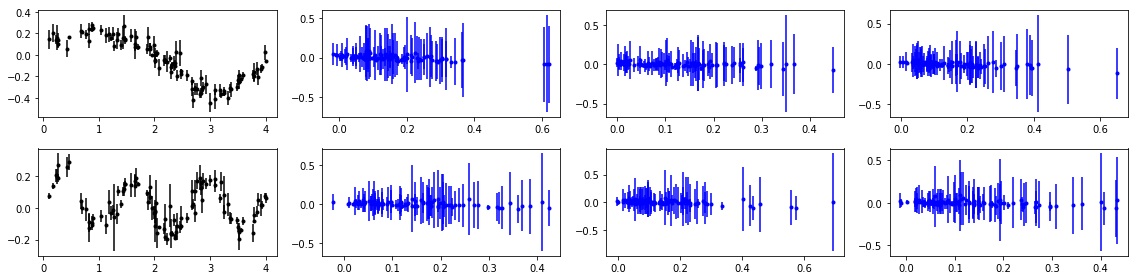

--------------- Epoch 71 ---------------


71 [D loss: 7.989345, acc: 0%] [G loss: 0.000000]
--------------- Epoch 72 ---------------


72 [D loss: 8.003523, acc: 0%] [G loss: 0.000000]
--------------- Epoch 73 ---------------


73 [D loss: 7.992329, acc: 0%] [G loss: 0.000000]
--------------- Epoch 74 ---------------


74 [D loss: 8.009260, acc: 0%] [G loss: 0.000000]
--------------- Epoch 75 ---------------


75 [D loss: 7.912831, acc: 0%] [G loss: 0.000000]
--------------- Epoch 76 ---------------


76 [D loss: 7.943927, acc: 0%] [G loss: 0.000000]
--------------- Epoch 77 ---------------


77 [D loss: 7.960955, acc: 0%] [G loss: 0.000000]
--------------- Epoch 78 ---------------


78 [D loss: 8.016801, acc: 0%] [G loss: 0.000000]
--------------- Epoch 79 ---------------


79 [D loss: 8.023505, acc: 0%] [G loss: 0.000000]
--------------- Epoch 80 ---------------


80 [D loss: 7.915210, acc: 0%] [G loss: 0.000000]


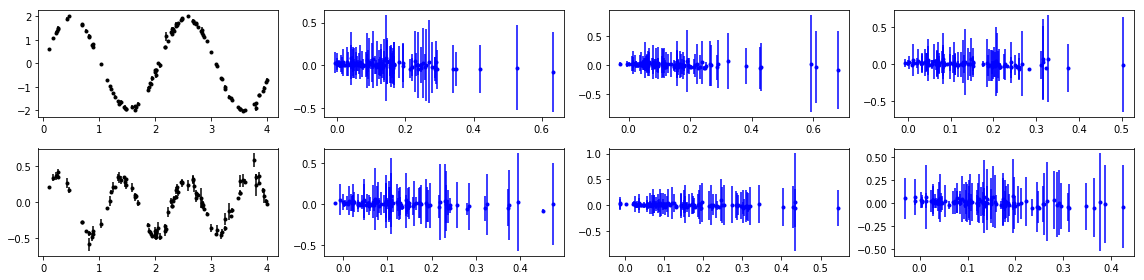

--------------- Epoch 81 ---------------


81 [D loss: 7.997805, acc: 0%] [G loss: 0.000000]
--------------- Epoch 82 ---------------


82 [D loss: 8.014094, acc: 0%] [G loss: 0.000000]
--------------- Epoch 83 ---------------


83 [D loss: 7.995237, acc: 0%] [G loss: 0.000000]
--------------- Epoch 84 ---------------


84 [D loss: 7.988720, acc: 0%] [G loss: 0.000000]
--------------- Epoch 85 ---------------


85 [D loss: 7.905125, acc: 0%] [G loss: 0.000000]
--------------- Epoch 86 ---------------


86 [D loss: 7.956405, acc: 0%] [G loss: 0.000000]
--------------- Epoch 87 ---------------


87 [D loss: 7.938186, acc: 0%] [G loss: 0.000000]
--------------- Epoch 88 ---------------


88 [D loss: 7.963628, acc: 0%] [G loss: 0.000000]
--------------- Epoch 89 ---------------


89 [D loss: 8.060659, acc: 0%] [G loss: 0.000000]
--------------- Epoch 90 ---------------


90 [D loss: 8.027578, acc: 0%] [G loss: 0.000000]


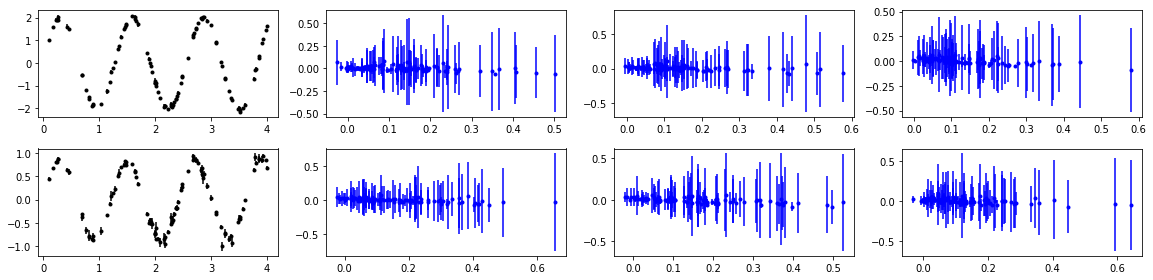

--------------- Epoch 91 ---------------


91 [D loss: 7.959658, acc: 0%] [G loss: 0.000000]
--------------- Epoch 92 ---------------


92 [D loss: 7.927354, acc: 0%] [G loss: 0.000000]
--------------- Epoch 93 ---------------


93 [D loss: 7.953855, acc: 0%] [G loss: 0.000000]
--------------- Epoch 94 ---------------


94 [D loss: 7.967716, acc: 0%] [G loss: 0.000000]
--------------- Epoch 95 ---------------


95 [D loss: 8.030762, acc: 0%] [G loss: 0.000000]
--------------- Epoch 96 ---------------


In [ ]:
#for l_rate in [.00001, .00002, .00005, .0001, .0002, .0005]:
if True:
    n_units = 16
    l_rate = .0001
    print('########## Learning Rate: %.4f ##########' % (l_rate))
    print('##########      N Unites: %i     ##########' % (n_units))
    # Build our GAN netowrk
    adam = get_optimizer(l_rate)
    generator = get_generator(adam, n_units, latent_dim, n_obs, n_feat, 
                              m_type='LSTM', bdir=False, n_layers=1,
                              dropout=G_dropout)
    discriminator = get_discriminator(adam, n_units, n_obs, n_feat, 
                                      m_type='LSTM', bdir=False, n_layers=1,
                                      dropout=D_dropout)
    
    print('generator')
    # print(generator.summary())
    print('discriminator')
    # print(discriminator.summary())
    gan = get_gan_network(discriminator, latent_dim, gen_lc_len, generator, adam)
    print('GAN')
    print(gan.summary())

    test_noise = get_noise(n_examples, latent_dim=latent_dim, 
                           n_timesteps=n_obs, use_time=True)

    # logger = TensorBoard(log_dir='%s/logs/%s_%s/run_%s/' % 
    #                      (main_path, model_name, data_name,
    #                       datetime.datetime.now().strftime("%y%m%d_%I%M")),
    #                      histogram_freq=0, write_graph=False, write_images=True)
    # logger.set_model(gan)
    loss_G, loss_D = [], []

    for e in range(1, n_epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for n_batch in tnrange(batch_count, desc='# batch'):

            # Get a random set of input noise and real LC's
            real_lc = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            # real_lc = x_train[n_batch*batch_size: (n_batch+1)*batch_size]
            real_lc_y = np.random.uniform(.9, 1., size=batch_size)
            # real_lc_y = np.ones(bcatch_size) # * .9

            # Generate fake LC's
            noise = get_noise(batch_size, latent_dim=latent_dim, 
                              n_timesteps=n_obs, use_time=True)
            gen_lc = generator.predict(noise)
            gen_lc_y = np.random.uniform(0., .1, size=batch_size)
            # gen_lc_y = np.ones(batch_size) * 0.

            # Train discriminator on real
            # discriminator.trainable = True
            # d_loss_real, d_acc_real = discriminator.train_on_batch(real_lc, real_lc_y)
            # Train discriminator on generated
            # d_loss_gen, d_acc_gen = discriminator.train_on_batch(gen_lc, gen_lc_y)
            # d_loss = d_loss_real + d_loss_gen
            # d_acc = (d_acc_real + d_acc_gen)/2
            
            X = np.concatenate([real_lc, gen_lc])
            y_dis = np.concatenate([real_lc_y, gen_lc_y])
            discriminator.trainable = True
            d_loss, d_acc = discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = get_noise(batch_size, latent_dim=latent_dim,
                              n_timesteps=n_obs, use_time=True)
            # y_gen = np.random.uniform(0.8, 1., size=batch_size)
            y_gen = np.ones(batch_size) # * .9
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)
            
            loss_G.append([(e-1) * batch_count + n_batch ,g_loss])
            loss_D.append([(e-1) * batch_count + n_batch ,d_loss])

            # if n_batch % 10 == 0:
            #     write_log_scalar(logger, ['G_loss', 'D_loss', 'D_acc'],
            #                      [g_loss, d_loss, d_acc],
            #                      (e-1) * batch_count + n_batch)

        print("%d [D loss: %f, acc: %.0f%%] [G loss: %f]" %
              (e, d_loss, d_acc*100, g_loss))
        if d_loss == 0:
            print('Failiure mode...')
            break

        if e == 1 or e % viz_interval == 0:
            lc_test = generator.predict(get_noise(n_examples, latent_dim=latent_dim,
                                                  n_timesteps=n_obs, use_time=False))
            img_buf = plot_generated_time_series(e, lc_test,
                                                 test_lc=x_test[np.random.randint(0,len(x_test),8)])

            # generator.save('%s/experiments/params/%s_%s_G_%i.hdf5' %
            #               (main_path, model_name, data_name, e))
            # discriminator.save('%s/experiments/params/%s_%s_D_%i.hdf5' %
            #                   (main_path, model_name, data_name, e))

            # write_log_plot(logger, img_buf, (e-1) * batch_count + n_batch)
    
    loss_G = np.array(loss_G)
    loss_D = np.array(loss_D)
    plt.plot(loss_G[:,0], loss_G[:,1], '-b', label='G', linewidth=1)
    plt.plot(loss_D[:,0], loss_D[:,1], '-r', label='D', linewidth=1)
    plt.xlabel('batch iter')
    plt.ylabel('Loss')
    plt.legend(loc='best')jajajaja
    plt.show()
